# Deep Latent Policy Gradient for Ant

In [1]:
import gym,warnings,time
warnings.filterwarnings("ignore") # Stop annoying warnings
gym.logger.set_level(40)
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim 
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from custom_ant import AntEnvCustom # Custom ant
from lgrp_class import lgrp_class # Gaussian random path
from vae_class import vae_class # VAE
from util import PID_class,display_frames_as_gif,\
    quaternion_to_euler_angle,multi_dim_interp,cpu_sess
print ("TF version is [%s]."%(tf.__version__))

Instructions for updating:
Use the retry module or similar alternatives.
TF version is [1.7.0].


### Define ant training environment

In [2]:
class antTrainEnv_class(object):
    def __init__(self):
        # Some parameters
        self.tMin = 0
        self.tMax = 3
        self.nAnchor = 20
        self.maxRepeat = 3
        
        # Initialize Ant gym 
        self.env = AntEnvCustom()
        # GRP sampler (prior)
        nDataPrior = 2
        nTest = (int)((self.tMax-self.tMin)/self.env.dt)
        tData = np.linspace(start=self.tMin,stop=self.tMax,num=nDataPrior).reshape((-1,1))
        xData = np.random.rand(nDataPrior,self.env.actDim) # Random positions 
        xData[0,:] = xData[0,:]/3.0+1.0/3.0
        xData[-1,:] = xData[0,:]
        lData = np.ones(shape=(nDataPrior,1))
        tTest = np.linspace(start=self.tMin,stop=self.tMax,num=nTest).reshape((-1,1))
        lTest = np.ones(shape=(nTest,1))
        hyp = {'gain':1/2,'len':1/4,'noise':1e-8} # {'gain':1/4,'len':1/3,'noise':1e-8}
        self.GRPprior = lgrp_class(_name='GPR Prior',_tData=tData,
                                   _xData=xData,_lData=lData,_tTest=tTest,
                                   _lTest=lTest,_hyp=hyp)
        self.GRPprior.plot_all(_nPath=10,_figsize=(12,4))
        # GRP posterior
        tData = np.linspace(start=self.tMin,stop=self.tMax,num=self.nAnchor).reshape((-1,1))
        xData = np.random.rand(self.nAnchor,self.env.actDim) # Random positions 
        lData = np.ones(shape=(self.nAnchor,1))
        lData[1:self.nAnchor-1] = 0.5
        self.GRPposterior = lgrp_class(_name='GPR Posterior',_tData=tData,
                                   _xData=xData,_lData=lData,_tTest=tTest,
                                   _lTest=lTest,_hyp=hyp)
        self.GRPposterior.plot_all(_nPath=10,_figsize=(12,4))
        # PID controller 
        self.PID = PID_class(Kp=0.01,Ki=0.00001,Kd=0.002,windup=5000,
                        sample_time=self.env.dt,dim=self.env.actDim)
        # VAE (this will be our policy function)
        self.VAE = vae_class(_name='VAE',_xDim=self.nAnchor*self.env.actDim,
                             _zDim=16,_hDims=[64,32],_cDim=0,
                             _actv=tf.nn.softplus,_bn=None,
                             _optimizer=tf.train.AdamOptimizer,
                             _optm_param={'lr':0.001,'beta1':0.9,'beta2':0.9,'epsilon':1e-8},
                             _VERBOSE=False)
    # Scale-up trajectory
    def scale_up_traj(self,rawTraj):
        return self.env.minPosDeg+(self.env.maxPosDeg-self.env.minPosDeg)*rawTraj
    
    # Rollout trajectory
    def rollout(self,_pursuitTraj,_maxRepeat=1,_VERBOSE=True):
        lenTraj = _pursuitTraj.shape[0]
        cntRepeat = 0
        # Reset
        obs = self.env.reset_model()
        self.PID.clear()
        for i in range(10): 
            sec = self.env.sim.data.time
            refPosDeg = _pursuitTraj[0,:]
            cPosDeg = np.asarray(obs[5:13])*180.0/np.pi # Current pos
            degDiff = cPosDeg-refPosDeg
            self.PID.update(degDiff,sec)
            action = self.PID.output
            actionRsh = action[[6,7,0,1,2,3,4,5]] # rearrange
            obs,_,_,_ = self.env.step(actionRsh)
        self.PID.clear() # Reset PID after burn-in
        self.env.sim.data.time = 0
        tick,frames,titleStrs = 0,[],[]
        tickPursuit = 0
        timeList = np.zeros(shape=(lenTraj*_maxRepeat)) # 
        cPosDegList = np.zeros(shape=(lenTraj*_maxRepeat,self.env.actDim)) # Current joint trajectory
        rPosDegList = np.zeros(shape=(lenTraj*_maxRepeat,self.env.actDim)) # Reference joint trajectory
        rewardSum = 0
        xInit = self.env.get_body_com("torso")[0]
        hInit = self.env.get_heading()
        rewards = []
        while cntRepeat < _maxRepeat:
            # Some info
            sec = self.env.sim.data.time # Current time 
            x = self.env.get_body_com("torso")[0]
            q = self.env.data.get_body_xquat('torso')
            rX,rY,rZ = quaternion_to_euler_angle(q[0],q[1],q[2],q[3])

            # Render 
            frame = self.env.render(mode='rgb_array',width=200,height=200)
            frames.append(frame) # Append to frames for futher animating 
            titleStrs.append('%.2fsec x:[%.2f] heading:[%.1f]'%(sec,x,rZ))

            # PID controller 
            timeList[tick] = sec
            refPosDeg = _pursuitTraj[min(tickPursuit,lenTraj-1),:]
            rPosDegList[tick,:] = refPosDeg
            cPosDeg = np.asarray(obs[5:13])*180.0/np.pi # Current pos
            cPosDegList[tick,:] = cPosDeg
            degDiff = cPosDeg-refPosDeg
            self.PID.update(degDiff,sec)

            # Do action 
            action = self.PID.output
            actionRsh = action[[6,7,0,1,2,3,4,5]] # rearrange
            obs,reward,done,rwdDetal = self.env.step(actionRsh.astype(np.float16))
            rewardSum += reward
            rewards.append(reward)

            # Print out (for debugging)
            DO_PRINT = False
            if DO_PRINT:
                print ('sec: [%.2f] done: %s'%(sec,done))
                print (' cPosDeg:   %s'%(np.array2string(cPosDeg,precision=2,
                    formatter={'float_kind':lambda x: "%.2f" % x},
                    separator=', ',suppress_small=False,sign=' ')))
                print (' refPosDeg: %s'%(np.array2string(refPosDeg,precision=2,
                    formatter={'float_kind':lambda x: "%.2f" % x},
                    separator=', ',suppress_small=False,sign=' ')))           
                print (' degDiff:   %s'%(np.array2string(degDiff,precision=2,
                    formatter={'float_kind':lambda x: "%.2f" % x},
                    separator=', ',suppress_small=False,sign=' ')))
                print (' action:    %s'%(np.array2string(action,precision=2,
                    formatter={'float_kind':lambda x: "%.2f" % x},
                    separator=', ',suppress_small=False,sign=' ')))
                print (' reward:    %.3f (fwd:%.3f+ctrl:%.3f+contact:%.3f+survive:%.3f)'
                    %(reward,rwdDetal['reward_forward'],rwdDetal['reward_ctrl'],
                      rwdDetal['reward_contact'],rwdDetal['reward_survive']))
            # Increase tick 
            tick += 1
            tickPursuit += 1
            # Loop handler
            if tickPursuit >= lenTraj:
                cntRepeat += 1
                tickPursuit = 0
        xFinal = self.env.get_body_com("torso")[0]
        hFinal = self.env.get_heading()
        xDisp = xFinal - xInit
        hDisp = hFinal - hInit
        if _VERBOSE:
            print ("Repeat:[%d] done. Avg reward is [%.3f]. xDisp is [%.3f]. hDisp is [%.3f]."
                   %(maxRepeat,rewardSum/tick,xDisp,hDisp))
        ret = {'rewards':rewards,'frames':frames,'titleStrs':titleStrs,
              'xDisp':xDisp,'hDisp':hDisp}
        return ret
    
    # Sample from GRP prior
    def sample_from_grp_prior(self):
        # Sample Trajectory for GP prior
        sampledTraj = self.GRPprior.sample_paths(_nPath=1)[0]
        # Scale up
        pursuitTraj = self.scale_up_traj(sampledTraj)
        return pursuitTraj,sampledTraj
    
    # Rollout from given trajectory
    def unit_rollout_from_traj(self,_pursuitTraj,_maxRepeat=3):
        ret = self.rollout(_pursuitTraj,_maxRepeat,_VERBOSE=False)
        avgRwd = np.asarray(ret['rewards'],dtype=np.float32).mean()
        return avgRwd,ret

    # Get anchor poiints from trajecotry
    def get_anchor_from_traj(self,_sampledTraj):
        tInterp = np.linspace(start=self.tMin,stop=self.tMax,
                      num=self.nAnchor).reshape((-1,1))
        xInterp = multi_dim_interp(tInterp,self.GRPprior.tTest,_sampledTraj)
        return xInterp
    
    # Set anchor points to GRP posterior
    def set_anchor_grp_posterior_from_traj(self,_sampledTraj,_levBtw=0.8):
        tInterp = np.linspace(start=self.tMin,stop=self.tMax,
                      num=self.nAnchor).reshape((-1,1))
        xInterp = multi_dim_interp(tInterp,self.GRPprior.tTest,_sampledTraj)
        lInterp = np.ones_like(tInterp)
        lInterp[1:AntEnv.nAnchor-1] = _levBtw
        self.GRPposterior.set_data(_tData=tInterp,_xData=xInterp,_lData=lInterp,
                                   _EPS_RU=True)
        
    # Set anchor points to GRP posterior
    def set_anchor_grp_posterior(self,_anchors,_levBtw=0.8):
        tInterp = np.linspace(start=self.tMin,stop=self.tMax,
                      num=self.nAnchor).reshape((-1,1))
        xInterp = _anchors
        lInterp = np.ones_like(tInterp)
        lInterp[1:AntEnv.nAnchor-1] = _levBtw
        self.GRPposterior.set_data(_tData=tInterp,_xData=xInterp,_lData=lInterp,
                                   _EPS_RU=True)
    
    # Rollout from GRP posterior 
    def unit_rollout_from_grp_prior(self,_maxRepeat):
        pursuitTraj,sampledTraj = self.sample_from_grp_prior()
        avgRwd,ret = self.unit_rollout_from_traj(pursuitTraj,_maxRepeat=_maxRepeat)
        ret['sampledTraj'] = sampledTraj
        ret['pursuitTraj'] = pursuitTraj
        return avgRwd,ret
    
    # Rollout from GRP posterior 
    def unit_rollout_from_grp_posterior(self,_maxRepeat):
        sampledTraj = self.GRPposterior.sample_paths(_nPath=1)[0]
        pursuitTraj = self.scale_up_traj(sampledTraj)
        avgRwd,ret = self.unit_rollout_from_traj(pursuitTraj,_maxRepeat=_maxRepeat)
        ret['sampledTraj'] = sampledTraj
        ret['pursuitTraj'] = pursuitTraj
        return avgRwd,ret
    
    # Rollout from GRP mean
    def unit_rollout_from_grp_mean(self,_maxRepeat):
        pursuitTraj = self.scale_up_traj(self.GRPposterior.muTest)
        avgRwd,ret = self.unit_rollout_from_traj(pursuitTraj,_maxRepeat=_maxRepeat)
        ret['sampledTraj'] = self.GRPposterior.muTest
        ret['pursuitTraj'] = pursuitTraj
        return avgRwd,ret
    
print ("Class Ready")

Class Ready


### Instantiate Class

Custom Ant Environment made by SJ.


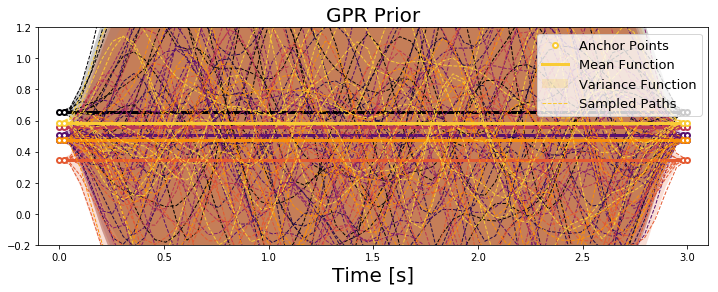

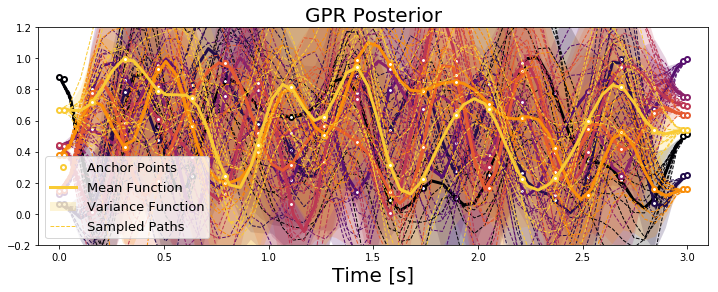

In [3]:
tf.reset_default_graph() # Reset Graph 
AntEnv = antTrainEnv_class() # Test

### Sample from prior and rollout => Set posterior and rollout from mean and sampled

Creating window glfw
[Prior] avgRwd:[0.622] xDisp:[-0.478] hDisp:[-37.918]
[Post]  avgRwd:[0.689] xDisp:[-0.159] hDisp:[84.190]
[Mean]  avgRwd:[0.822] xDisp:[1.053] hDisp:[40.716]


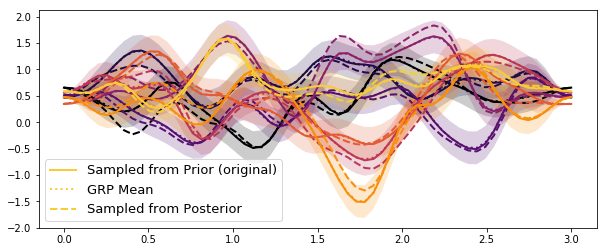

In [4]:
# Sample Trajectory for GP prior
avgRwdPrior,retPrior = AntEnv.unit_rollout_from_grp_prior(AntEnv.maxRepeat)
print ("[Prior] avgRwd:[%.3f] xDisp:[%.3f] hDisp:[%.3f]"%
       (avgRwdPrior,retPrior['xDisp'],retPrior['hDisp']))
# Set anchor points from trajectory
AntEnv.set_anchor_grp_posterior_from_traj(retPrior['sampledTraj'],_levBtw=0.8)
avgRwdPost,retPost = AntEnv.unit_rollout_from_grp_posterior(AntEnv.maxRepeat)
print ("[Post]  avgRwd:[%.3f] xDisp:[%.3f] hDisp:[%.3f]"%
       (avgRwdPost,retPost['xDisp'],retPost['hDisp']))
avgRwdMean,retMean = AntEnv.unit_rollout_from_grp_mean(AntEnv.maxRepeat)
print ("[Mean]  avgRwd:[%.3f] xDisp:[%.3f] hDisp:[%.3f]"%
       (avgRwdMean,retMean['xDisp'],retMean['hDisp']))
# Plot
cmap = plt.get_cmap('inferno')
colors = [cmap(i) for i in np.linspace(0,1,AntEnv.env.actDim+1)]
plt.figure(figsize=(10,4))
muTest = AntEnv.GRPposterior.muTest
sigmaTest = np.sqrt(AntEnv.GRPposterior.varTest)
for dIdx in range(AntEnv.env.actDim):
    plt.fill_between(AntEnv.GRPposterior.tTest.squeeze(),
                     (muTest[:,dIdx:dIdx+1]-2*sigmaTest).squeeze(),
                     (muTest[:,dIdx:dIdx+1]+2*sigmaTest).squeeze(),
                     facecolor=colors[dIdx], interpolate=True, alpha=0.2)
    hPrior,=plt.plot(AntEnv.GRPposterior.tTest,retPrior['sampledTraj'][:,dIdx],
             '-',color=colors[dIdx],lw=2)
    hMean,=plt.plot(AntEnv.GRPposterior.tTest,retMean['sampledTraj'][:,dIdx],
             ':',color=colors[dIdx],lw=2)
    hPost,=plt.plot(AntEnv.GRPposterior.tTest,retPost['sampledTraj'][:,dIdx],
             '--',color=colors[dIdx],lw=2)
plt.legend([hPrior,hMean,hPost],
       ['Sampled from Prior (original)','GRP Mean','Sampled from Posterior'],
       fontsize=13)
plt.show()

### VAE related

In [5]:
sess = cpu_sess()
sess.run(tf.global_variables_initializer()) # Initialize VAE weights

maxEpoch = 100
batchSize = 100
for _epoch in range(maxEpoch):
    priorProb = np.exp(-10*(_epoch/maxEpoch)**2)
    # Expirence memory
    xList = np.zeros((batchSize,AntEnv.env.actDim*AntEnv.nAnchor))
    qList = np.zeros((batchSize))
    xDispList = np.zeros((batchSize))
    for _iter in range(batchSize):
        np.random.seed((int)(time.time())) # Shuffle seed 
        if np.random.rand() < priorProb: # Sample from prior
            avgRwd,ret = AntEnv.unit_rollout_from_grp_prior(AntEnv.maxRepeat)
        else: # Sample from posterior (VAE)
            sampledX = AntEnv.VAE.sample(_sess=sess).reshape((AntEnv.nAnchor,AntEnv.env.actDim))
            AntEnv.set_anchor_grp_posterior(_anchors=sampledX,_levBtw=0.8+0.2*(1-priorProb))
            avgRwd,ret = AntEnv.unit_rollout_from_grp_posterior(AntEnv.maxRepeat)
        # Get anchor points
        xInterp = AntEnv.get_anchor_from_traj(ret['sampledTraj'])
        xVec = np.reshape(xInterp,newshape=(1,-1))
        # Append
        xList[_iter,:] = xVec
        qList[_iter] = avgRwd
        xDispList[_iter] = ret['xDisp']
        # Print
        if False:
            print ("  [%d/%d][%d/%d] rwd:[%.2f] xDisp:[%.3f]"%
                   (_epoch,maxEpoch,_iter,batchSize,avgRwd,ret['xDisp']))
    # Train
    xListClipped = np.clip(xList,0,1) # Clip 
    AntEnv.VAE.train(_sess=sess,_X=xList,_Y=None,_C=None,_Q=10.0*(qList-1.0),
                     _maxIter=50,_batchSize=64,_PRINT_EVERY=0,_PLOT_EVERY=0,
                     _INIT_VAR=False)
    # Print
    print ("[%d/%d] priorProb:[%.2f] avgRwd:[%.3f] XdispMean:[%.3f] XdispVar:[%.3f]"%
           (_epoch,maxEpoch,priorProb,qList.mean(),xDispList.mean(),xDispList.var()))

[0/100] priorProb:[1.00] avgRwd:[0.766] XdispMean:[0.121] XdispVar:[1.077]
[1/100] priorProb:[1.00] avgRwd:[0.738] XdispMean:[-0.149] XdispVar:[1.975]
[2/100] priorProb:[1.00] avgRwd:[0.722] XdispMean:[-0.247] XdispVar:[1.918]
[3/100] priorProb:[0.99] avgRwd:[0.729] XdispMean:[-0.197] XdispVar:[2.007]
[4/100] priorProb:[0.98] avgRwd:[0.729] XdispMean:[-0.138] XdispVar:[1.426]
[5/100] priorProb:[0.98] avgRwd:[0.700] XdispMean:[-0.398] XdispVar:[1.268]
[6/100] priorProb:[0.96] avgRwd:[0.736] XdispMean:[0.031] XdispVar:[1.677]


KeyboardInterrupt: 

In [ ]:
display_frames_as_gif(ret['frames'],_intv_ms=20,_figsize=(8,8),_fontsize=15,
                      _titleStrs=ret['titleStrs'])